In [2]:
from synthetic_data import JetSequence

jet_seq = JetSequence(filepath='/home/df630/SyntheticJets/data/TTBar_val___1Mfromeach_403030.h5', )
jets = jet_seq.map_to_sequence()


INFO: start token: None
INFO: end token: None
INFO: pad token: -1


In [3]:
jets

array([[32161, 28317, 26395, ...,    -1,    -1,    -1],
       [30368, 24504, 23543, ...,    -1,    -1,    -1],
       [27356, 25402, 25434, ...,    -1,    -1,    -1],
       ...,
       [25591, 25275, 24631, ...,    -1,    -1,    -1],
       [32191, 25464, 23487, ...,    -1,    -1,    -1],
       [27387, 25465, 25466, ...,    -1,    -1,    -1]], dtype=int16)

In [4]:
jets_bins = jet_seq.seq_to_bins_decoding(jets)
jets_bins[0]

array([[33, 14, 14],
       [29, 14, 14],
       [27, 14, 14],
       [25, 14, 14],
       [24, 17, 15],
       [23, 17, 15],
       [22, 14, 14],
       [21, 16, 14],
       [21, 14, 14],
       [19, 17, 28],
       [18, 17, 15],
       [17, 16, 27],
       [15, 14, 14],
       [15, 15, 14],
       [14, 14, 14],
       [12, 16, 29],
       [12, 15, 17],
       [11, 16, 15],
       [11, 17, 25],
       [11, 14, 15],
       [10, 13, 27],
       [ 9, 20, 14],
       [ 8, 21, 19],
       [ 8,  8,  4],
       [ 8, 14, 14],
       [ 7, 18, 26],
       [ 6, 17, 14],
       [ 6, 20, 17],
       [ 5, 19, 15],
       [ 5, 16, 15],
       [ 4,  3, 18],
       [-1, -1, -1],
       [-1, -1, -1],
       [-1, -1, -1],
       [-1, -1, -1],
       [-1, -1, -1],
       [-1, -1, -1],
       [-1, -1, -1],
       [-1, -1, -1],
       [-1, -1, -1],
       [-1, -1, -1],
       [-1, -1, -1],
       [-1, -1, -1],
       [-1, -1, -1],
       [-1, -1, -1],
       [-1, -1, -1],
       [-1, -1, -1],
       [-1, -

In [5]:
jets_bins.shape

(800000, 199, 3)

In [1]:
# open yaml file

import yaml

def read_yaml_file(file_path):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print(f"Error reading YAML file: {e}")
            return None

bin_edges = read_yaml_file('bin_edges.yaml')
(bin_edges['pt'][idx + 1] - bin_edges['pt'][idx]) * 0.5

In [10]:
mask = (jets != jet_seq.pad_token)
multiplicity = mask.sum(axis=1)

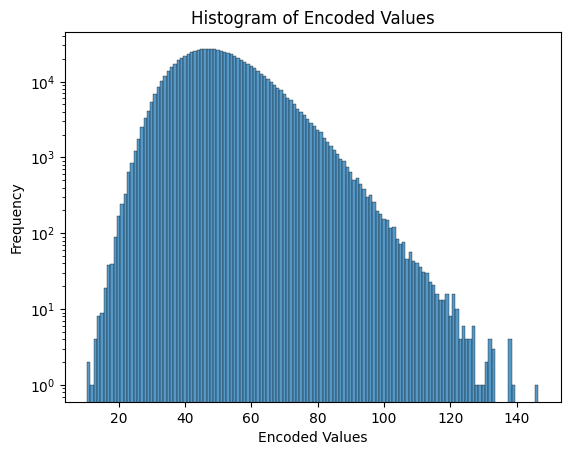

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(multiplicity, discrete=True)

plt.xlabel('Encoded Values')
plt.ylabel('Frequency')
plt.title('Histogram of Encoded Values')
plt.yscale('log')
plt.show()

## Generate jet sequences

In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as L

from torch.utils.data import DataLoader
from models import JetGPT2Model

###############################################################################
N = 3500  # num gen jets
tag = 'fine'
signal_id = "e66587b2c59b4773a97aa4afabd9b095"        # comet run folder
path = "/home/df630/SyntheticJets/experiments/results/comet/tokenized-jets/"
###############################################################################

#...Signal

#...load ckpt and generate data from pretrained GPT2

sig_gpt2 = JetGPT2Model.load_from_checkpoint(f"{path}/{signal_id}/checkpoints/best.ckpt")
sig_gpt2.top_k = sig_gpt2.start_token # remove top_k default cut
prompts = torch.full((N, 1), sig_gpt2.start_token, dtype=torch.long, device=sig_gpt2.device)
prompt_dataloadeer = DataLoader(prompts, batch_size=1024, shuffle=False)


generator = L.Trainer(accelerator="gpu", devices=[0])
sig_gen_seq = generator.predict(sig_gpt2, dataloaders=prompt_dataloadeer)
sig_gen_seq = torch.cat(sig_gen_seq, dim=0)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/df630/.conda/envs/markov_bridges/lib/python3.10/site-packages/pytorch_lightning-2.5.0.post0-py3.10.egg/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

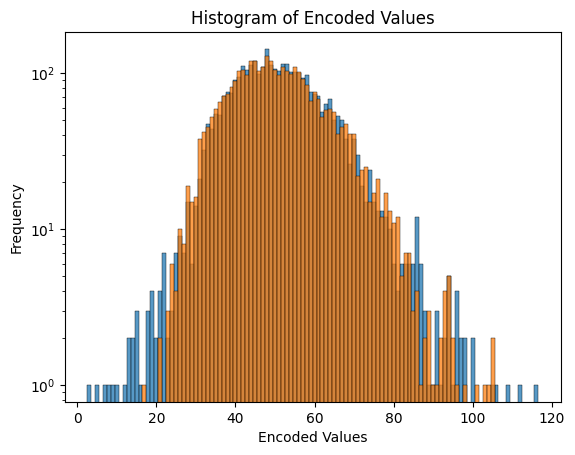

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

test = torch.tensor(jets[:3500])


sns.histplot((sig_gen_seq != -1).sum(dim=1), discrete=True)
sns.histplot((test != -1).sum(dim=1), discrete=True )
plt.xlabel('Encoded Values')
plt.ylabel('Frequency')
plt.title('Histogram of Encoded Values')
plt.yscale('log')
plt.show()

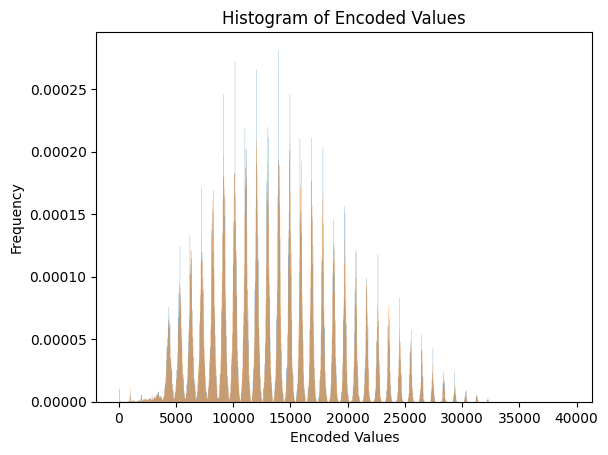

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(sig_gen_seq[sig_gen_seq>=0], lw=0,  bins=1000, fill=True, alpha=0.5, label='sample', element='step', stat='density')
sns.histplot(test[test >=0],  lw=0,  bins=1000, fill=True, alpha=0.5, label='test', element='step', stat='density')

plt.xlabel('Encoded Values')
plt.ylabel('Frequency')
plt.title('Histogram of Encoded Values')
plt.show()

In [20]:
sig_gen_bins = jet_seq.seq_to_bins_decoding(sig_gen_seq)
test_bins = jet_seq.seq_to_bins_decoding(test)

gen_mask  = sig_gen_bins[...,0] >= 0
test_mask = test_bins[...,0] >= 0

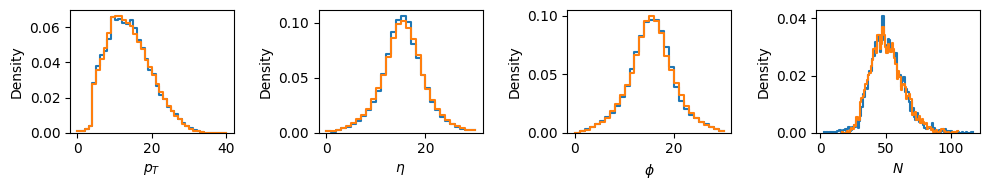

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 4, figsize=(10, 2))
sns.histplot(sig_gen_bins[...,0][gen_mask],   bins=np.arange(0,41,1),  fill=False,   label='gpt2', element='step', stat='density', ax=ax[0])
sns.histplot(test_bins[...,0][test_mask],  bins=np.arange(0,41,1),   fill=False, label='test', element='step', stat='density', ax=ax[0])
sns.histplot(sig_gen_bins[...,1][gen_mask],   bins=np.arange(0,31,1), fill=False,  label='gpt2', element='step', stat='density', ax=ax[1])
sns.histplot(test_bins[...,1][test_mask],   bins=np.arange(0,31,1), fill=False,  label='test', element='step', stat='density', ax=ax[1])
sns.histplot(sig_gen_bins[...,2][gen_mask], bins=np.arange(0,31,1), fill=False,  label='gpt2', element='step', stat='density', ax=ax[2])
sns.histplot(test_bins[...,2][test_mask],  bins=np.arange(0,31,1), fill=False, label='test', element='step', stat='density', ax=ax[2])
sns.histplot((sig_gen_seq != -1).sum(dim=1), discrete=True,  fill=False,  label='gpt2', element='step', stat='density', ax=ax[3])
sns.histplot((test != -1).sum(dim=1), discrete=True ,  fill=False,  label='test', element='step', stat='density', ax=ax[3])

ax[0].set_xlabel(r'$p_T$')
ax[1].set_xlabel(r'$\eta$')
ax[2].set_xlabel(r'$\phi$')
ax[3].set_xlabel(r'$N$')
plt.tight_layout()
plt.show()